In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler


In [2]:
df = pd.read_csv('../data/final_dataset.csv', dtype=np.float32)
df.describe()

,date,open,high,low,close,volume
count,74456.000000,74456.000000,74456.000000,74456.000000,74456.000000,7.445600e+04
mean,1551.727539,17561.365234,17645.437500,17472.281250,17562.277344,1.350327e+06
std,895.626404,17444.855469,17530.271484,17353.328125,17445.787109,2.814610e+06
min,1.000000,0.000000,243.600006,0.000000,243.600006,0.000000e+00
25%,776.000000,3893.802551,3909.609924,3879.997498,3893.919983,1.060162e+05
50%,1552.000000,9674.774902,9720.584961,9626.750000,9675.180176,4.637802e+05
75%,2327.000000,28517.881836,28623.537109,28411.072754,28521.245117,1.442926e+06
max,3103.000000,73612.773438,73797.679688,73260.343750,73612.773438,1.039629e+08


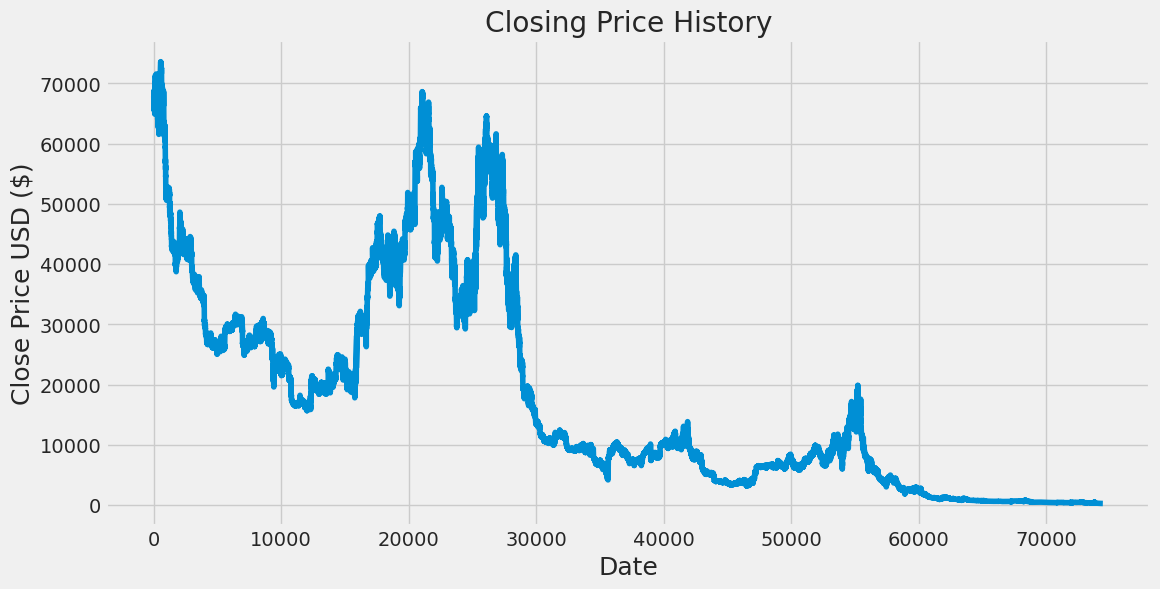

In [3]:
# Historical view of closing price
plt.figure(figsize=(12, 6))
plt.title('Closing Price History')
plt.plot(df['close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

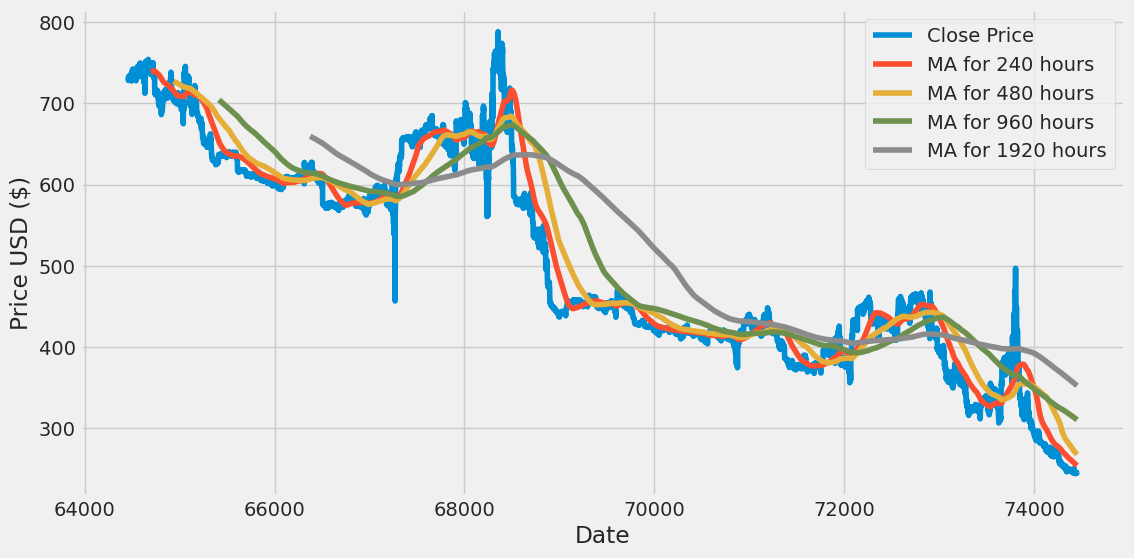

In [4]:
# Assuming df is your DataFrame containing Bitcoin price data
latest_entries_df = df.iloc[-10000:]

# Moving averages for 10 day, 20 days, 40 days, 80 days
ma_day = [240, 480, 960, 1920]
moving_averages = {}  # Dictionary to store moving averages

# Calculate moving averages
for ma in ma_day:
    column_name = f"MA for {ma} hours"
    moving_averages[column_name] = latest_entries_df['close'].rolling(window=ma).mean()

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(latest_entries_df['close'], label='Close Price')

# Plotting moving averages
for ma, ma_values in moving_averages.items():
    ax.plot(ma_values, label=ma)

ax.set_xlabel('Date')
ax.set_ylabel('Price USD ($)')
ax.legend()
plt.show()


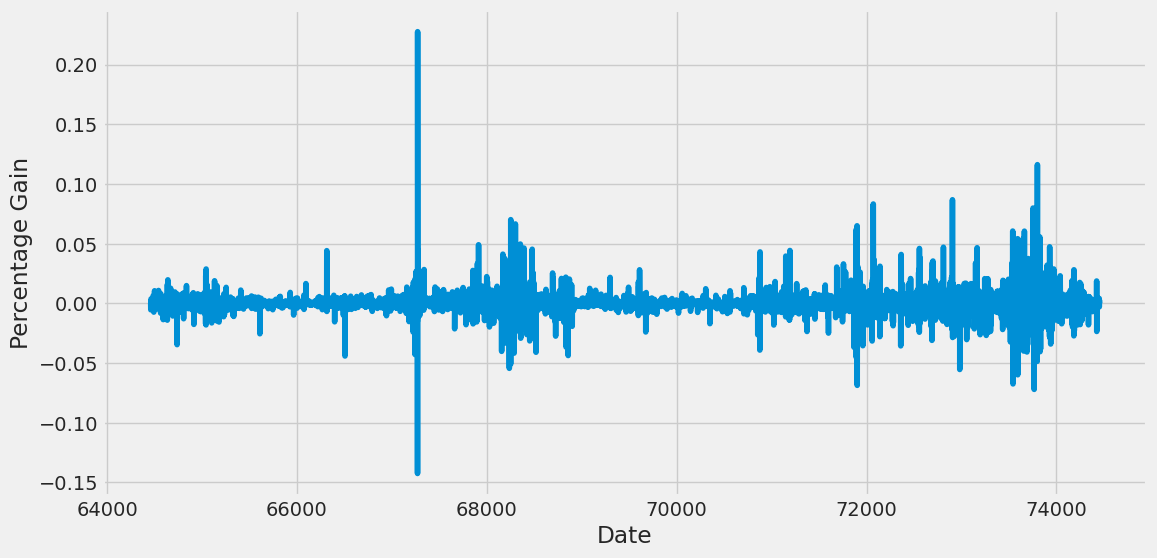

In [5]:
# Find percentage gains for each day
# Each day has the same date number
daily_return = latest_entries_df['close'] / latest_entries_df['close'].shift(1) - 1
daily_return = daily_return[1:]  # Remove first entry as it is NaN

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(daily_return)
ax.set_xlabel('Date')
ax.set_ylabel('Percentage Gain')
plt.show()

## Predictions

In [6]:
# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])  # Input features
        y.append(data[i+seq_length, -1])     # Target (close price)
    return np.array(X), np.array(y)

In [7]:
data = df.filter(['close'])
dataset = data.values
training_data_len = int(np.ceil( len(dataset) * .9 ))
print("Training data length:", training_data_len)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)


train_data = scaled_data[0:int(training_data_len), :]
x_train = []
y_train = []

for i in range(24, len(train_data)):
    x_train.append(train_data[i-24:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print(x_train.shape, y_train.shape)

Training data length: 67011
(66987, 24, 1) (66987,)


In [8]:
# Use torch for LSTM
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
    
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 150

for i in range(epochs):
    for seq, labels in zip(x_train, y_train):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

ModuleNotFoundError: No module named 'torch'

In [ ]:
# Save the model
torch.save(model.state_dict(), 'lstm_model.pth')

In [ ]:
# Test the model
test_data = scaled_data[training_data_len - 24: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(24, len(test_data)):
    x_test.append(test_data[i-24:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model(torch.tensor(x_test).float())
predictions = predictions.detach().numpy()
predictions = scaler.inverse_transform(predictions)

# Calculate RMSE
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
print("RMSE:", rmse)

In [ ]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

## Load and Use the model

In [ ]:
# Load the model
model = LSTM()
model.load_state_dict(torch.load('lstm_model.pth'))
model.eval()

# Predict next day
last_24_days = scaled_data[-24:]
last_24_days = np.reshape(last_24_days, (1, last_24_days.shape[0], 1))
last_24_days = torch.tensor(last_24_days).float()

prediction = model(last_24_days)
prediction = prediction.detach().numpy()
prediction = scaler.inverse_transform(prediction)

print("Predicted price for next day:", prediction[0][0])

In [ ]:
# 